In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Load the data from a CSV file
df = pd.read_csv('player_match_ratings.csv')
final_rating = pd.read_csv('final_ratings_tuned_human_ai.csv')

In [3]:
# 1) List of players (should be 524)
players_524 = sorted(df['player'].dropna().unique().tolist())
print(f"Number of players: {len(players_524)}")
# print(players_524[:15])  # uncomment to preview

# 2) Most frequent position per player (excluding 'sub')

pos_col = "pos"

def most_common_pos(series):
    s = (series.dropna().astype(str).str.lower().str.strip())
    s = s[~s.str.startswith('sub')]  # exclude 'sub'
    if s.empty:
        return pd.NA
    return s.mode().iloc[0]

pos_by_player = (df.groupby('player')[pos_col]
                   .apply(most_common_pos)
                   .rename('primary_pos'))

# 3) Per-minute averages for all numeric stats over total matches
if 'minutesPlayed' not in df.columns:
    raise ValueError("minutesPlayed column not found.")

num_cols = df.select_dtypes(include=['number']).columns.tolist()

# Exclude columns that are not player statistics
exclude_keywords = ['rating', 'w_min', 'difficulty', 'max_rank', 'expected', 'prob', 'elo']
exclude_cols = {'minutesPlayed'}
exclude_cols |= {c for c in num_cols if any(k in c.lower() for k in exclude_keywords)}
# Keep opponent ranking separate (context, not a stat to average per minute)
exclude_cols.add('opponent_ranking')

stat_cols = [c for c in num_cols if c not in exclude_cols]

# Aggregate totals
g = df.groupby('player', dropna=False)
totals = g[stat_cols + ['minutesPlayed']].sum(min_count=1)

# Per-minute rates (total_stat / total_minutes)
mins = totals['minutesPlayed'].replace(0, np.nan)
per_min = totals[stat_cols].div(mins, axis=0).add_suffix('_per_min')

# Optional: total minutes as a useful reference
per_min.insert(0, 'minutesPlayed_total', totals['minutesPlayed'])

# 4) Keep only the 3 final ratings from final_ratings_tuned_human_ai.csv
rating_cols_expected = ['final_rating_tuned', 'final_rating_human', 'final_rating_ai']
missing = [c for c in rating_cols_expected if c not in final_rating.columns]
if missing:
    raise ValueError(f"Missing columns in final_ratings_tuned_human_ai.csv: {missing}")

ratings3 = final_rating[['player'] + rating_cols_expected].copy()

# Build final table
player_summary = (per_min
                  .merge(pos_by_player, left_index=True, right_index=True, how='left')
                  .reset_index()
                  .merge(ratings3, on='player', how='left'))

# Ensure no other rating columns slipped in
other_rating_cols = [c for c in player_summary.columns
                     if ('rating' in c.lower()) and (c not in rating_cols_expected) and (c != 'primary_pos')]
if other_rating_cols:
    player_summary = player_summary.drop(columns=other_rating_cols)

print("player_summary shape:", player_summary.shape)
player_summary.head(10)

Number of players: 524
player_summary shape: (524, 58)


,player,minutesPlayed_total,goals_per_min,assists_per_min,shots_ontarget_per_min,shots_offtarget_per_min,shotsblocked_per_min,chances2score_per_min,drib_success_per_min,drib_unsuccess_per_min,...,flow_success_per_min,betweenness2goals_per_min,win_per_min,lost_per_min,is_home_team_per_min,game_duration_per_min,primary_pos,final_rating_tuned,final_rating_human,final_rating_ai
0,Aaron Cresswell,2984,0.000335,0.002346,0.001005,0.003686,0.001676,0.004357,0.001340,0.002681,...,0.010846,0.000138,0.003016,0.005027,0.006032,1.055630,df,5.207044,5.299785,4.736938
1,Aaron Hunt,2154,0.001393,0.000929,0.002321,0.006500,0.002786,0.010214,0.005107,0.003714,...,0.009630,0.000070,0.003714,0.006035,0.006500,1.169916,mf,6.441430,3.865245,6.995183
2,Aaron Lennon,1930,0.000000,0.001036,0.002591,0.005181,0.003627,0.004145,0.007772,0.005181,...,0.008896,0.000118,0.005181,0.005181,0.006736,1.305699,mf,3.189658,5.468924,3.094788
3,Aaron Mooy,3337,0.001199,0.000899,0.001798,0.006593,0.004795,0.004495,0.003596,0.003896,...,0.008724,0.000071,0.002397,0.005993,0.005694,1.051843,mf,11.121221,11.840611,7.911273
4,Aaron Ramsey,2206,0.003626,0.004533,0.011333,0.016772,0.008160,0.015866,0.011786,0.006346,...,0.016060,0.000332,0.008160,0.003626,0.005893,1.142339,mf,10.091666,10.381681,10.382094
5,Abdou Diallo,2326,0.000860,0.000000,0.001290,0.003439,0.000430,0.004729,0.012468,0.005159,...,0.011273,0.000073,0.003439,0.004729,0.006019,1.006019,df,10.450299,11.038219,8.766267
6,Abdoulaye Doucoure,3325,0.002105,0.000602,0.005113,0.008120,0.003609,0.006316,0.006917,0.003910,...,0.010807,0.000037,0.003308,0.005414,0.005714,1.001504,mf,10.496792,7.554244,9.129042
7,Adam Smith,2148,0.000466,0.000466,0.001397,0.004190,0.000466,0.003724,0.009311,0.010242,...,0.010607,0.000109,0.003259,0.005587,0.006518,1.131285,df,6.373137,4.796984,6.291618
8,Adam Szalai,1441,0.004164,0.000694,0.010409,0.013185,0.004164,0.016655,0.005552,0.004164,...,0.010654,0.000321,0.005552,0.004858,0.005552,1.374046,fw,4.473364,6.994771,6.446497
9,Admir Mehmedi,1456,0.002747,0.002060,0.004808,0.007555,0.002747,0.006181,0.006181,0.008242,...,0.010800,0.000351,0.004121,0.004808,0.004808,1.318681,mf,6.265796,5.560639,7.515631


In [4]:
import pandas as pd

# Save the final player summary
assert 'player_summary' in globals(), "Build player_summary first."
player_summary.to_csv('player_summary.csv', index=False)
print(f"Saved player_summary.csv with shape {player_summary.shape}")

Saved player_summary.csv with shape (524, 58)


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


51 features kept (time-related features removed)


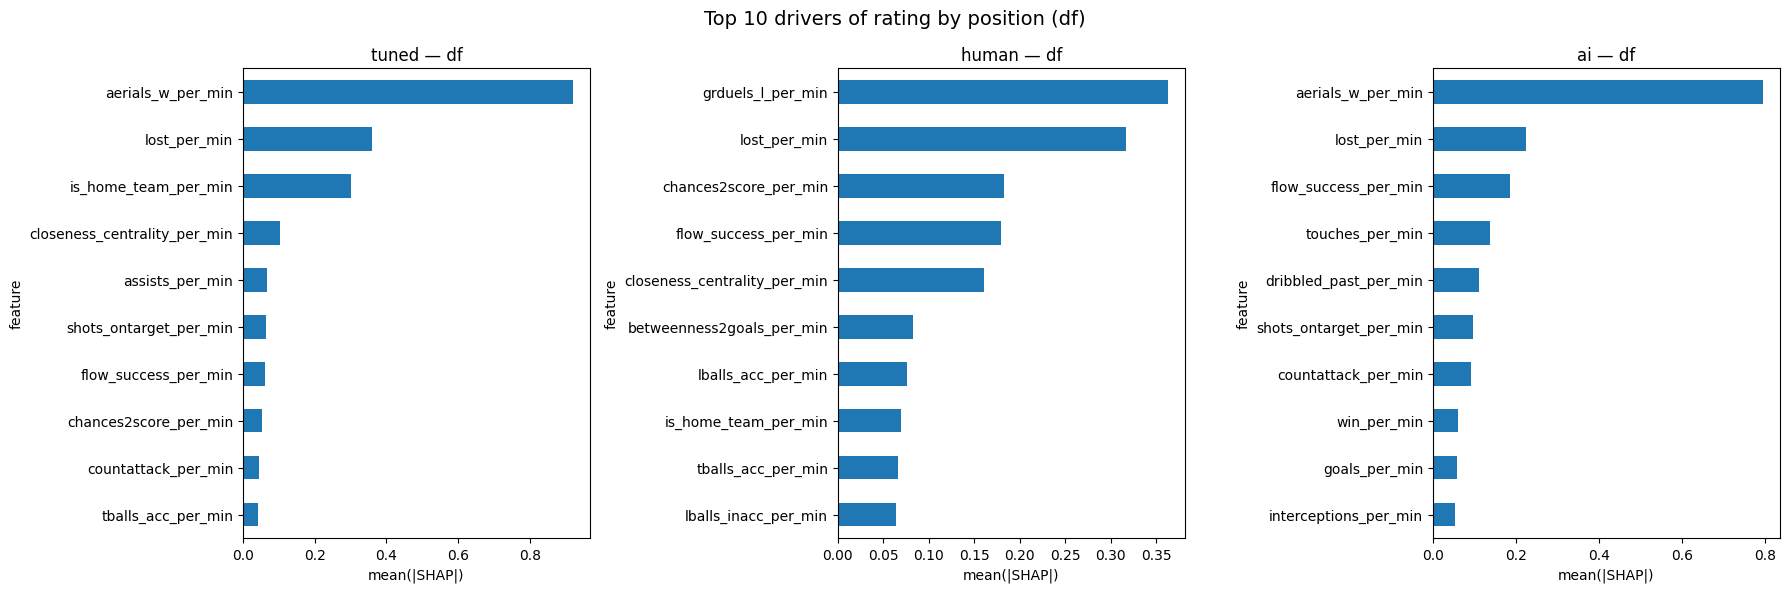

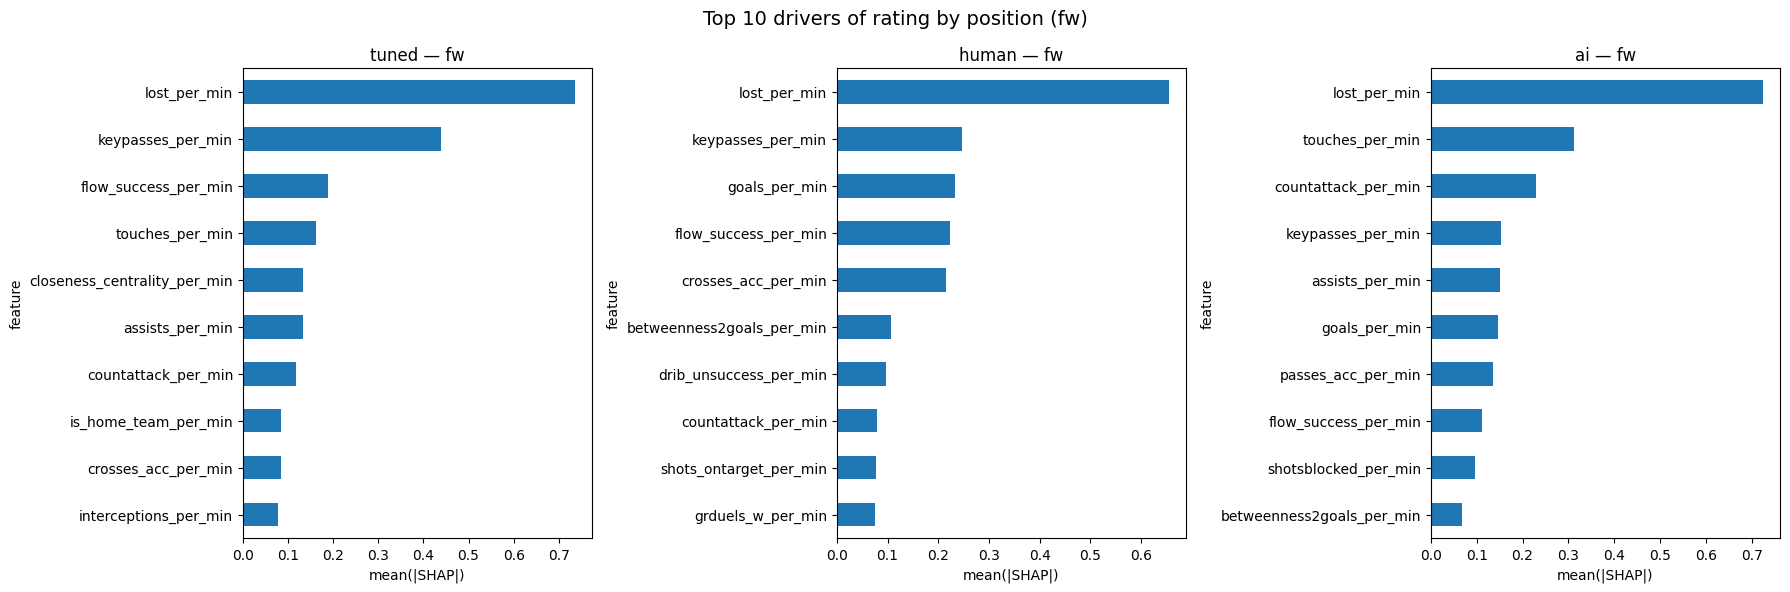

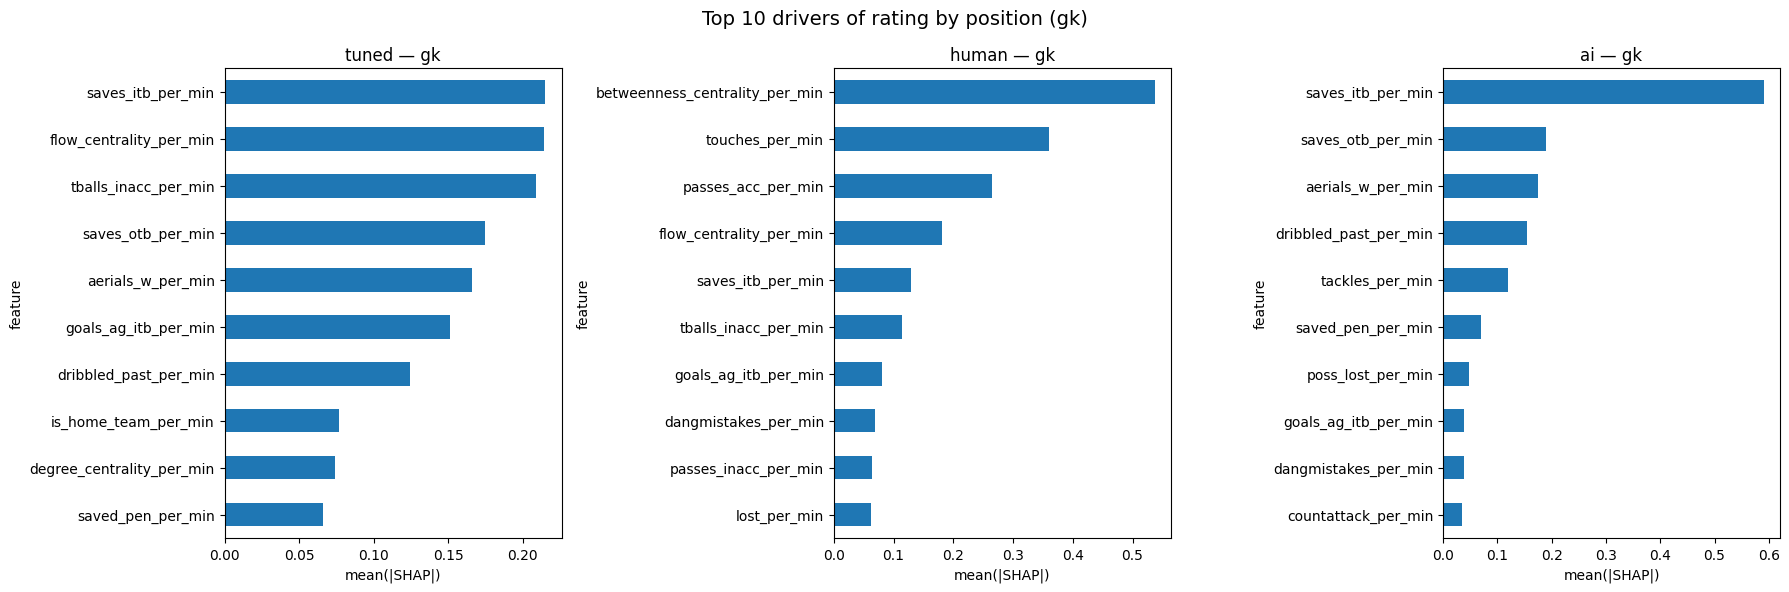

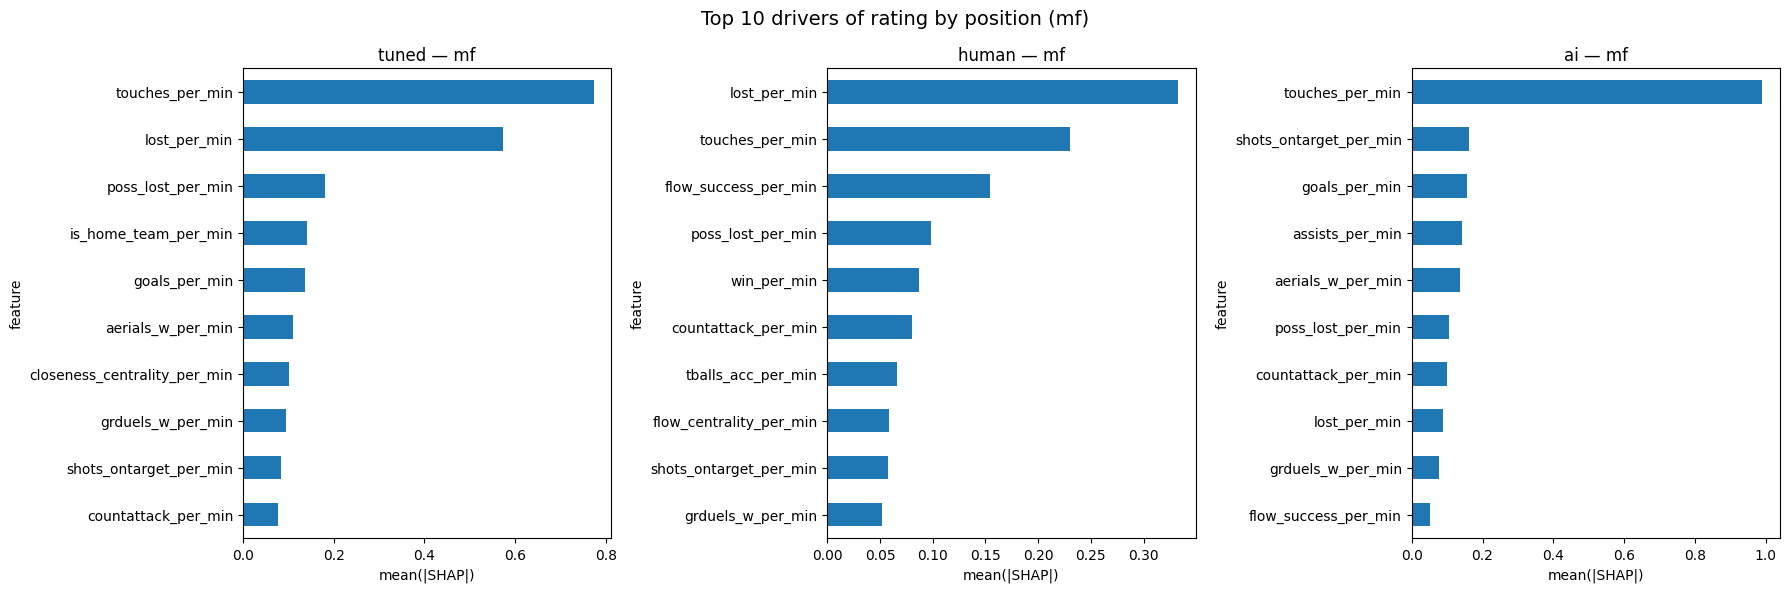

In [5]:
# Try to import shap; install if missing
try:
    import shap
except ImportError:
    import sys, subprocess
    subprocess.check_call([sys.executable, "-m", "pip", "install", "shap", "--quiet"])
    import shap

# Select feature columns: per-minute stats only, excluding time/minutes/duration metrics
all_per_min = [c for c in player_summary.columns if c.endswith('_per_min')]
time_keywords = {'minute','minutes','min','duration','time','second','seconds','stoppage','added','half','played'}

def is_time_feature(col):
    base = col[:-len('_per_min')] if col.endswith('_per_min') else col
    base = base.lower()
    return any(k in base for k in time_keywords)

feature_cols = [c for c in all_per_min if not is_time_feature(c)]
# Explicitly ensure minutesPlayed_total is not used
feature_cols = [c for c in feature_cols if c != 'minutesPlayed_total']
print(f"{len(feature_cols)} features kept (time-related features removed)")

# Targets for each system
systems = [
    ("tuned", "final_rating_tuned"),
    ("human", "final_rating_human"),
    ("ai",    "final_rating_ai"),
]

# Clean and guard
ps = player_summary.copy()
ps = ps.replace([np.inf, -np.inf], np.nan)
ps = ps.dropna(subset=['primary_pos'])  # need position
# Keep only rows with targets available for at least one system
ps_any = ps.dropna(subset=[t for _, t in systems], how='all')

def top_shap_importance(df_pos, ycol, top_n=10, min_rows=30):
    # Returns a Series of mean|SHAP| per feature (top_n), or None if not enough data
    df_pos = df_pos.dropna(subset=[ycol])
    if len(df_pos) < min_rows:
        return None
    X = df_pos[feature_cols].copy()
    # Drop columns that are entirely NA or constant
    valid_cols = [c for c in X.columns if X[c].notna().sum() > 0 and X[c].nunique(dropna=True) > 1]
    if not valid_cols:
        return None
    X = X[valid_cols]
    X = X.fillna(X.median(numeric_only=True))

    from sklearn.ensemble import RandomForestRegressor
    model = RandomForestRegressor(
        n_estimators=400,
        max_depth=None,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X, df_pos[ycol])

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)  # shape: (n_samples, n_features)
    mean_abs = np.abs(shap_values).mean(axis=0)
    imp = pd.Series(mean_abs, index=X.columns, name='mean_abs_shap').sort_values(ascending=False)
    return imp.head(top_n)

# Run per position, plot top features for each system
positions = sorted(ps_any['primary_pos'].dropna().unique())
top_n = 10
min_rows = 30  # skip very small samples to avoid noise

all_importances = {}  # {pos: {system: Series}}
for pos in positions:
    df_pos = ps_any[ps_any['primary_pos'] == pos]
    sys_imps = {}
    for sys_name, ycol in systems:
        imp = top_shap_importance(df_pos, ycol, top_n=top_n, min_rows=min_rows)
        if imp is not None and not imp.empty:
            sys_imps[sys_name] = imp
    if sys_imps:
        all_importances[pos] = sys_imps

# Plotting: one figure per position, 3 subplots (tuned, human, ai)
for pos, sys_imps in all_importances.items():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=False)
    titles = ["tuned", "human", "ai"]
    for ax, sys_name in zip(axes, titles):
        imp = sys_imps.get(sys_name)
        if imp is not None:
            imp.iloc[::-1].plot(kind='barh', ax=ax, color='#1f77b4')
            ax.set_title(f"{sys_name} — {pos}")
            ax.set_xlabel("mean(|SHAP|)")
            ax.set_ylabel("feature")
        else:
            ax.axis('off')
            ax.set_title(f"{sys_name} — {pos}\n(not enough data)")
    fig.suptitle(f"Top {top_n} drivers of rating by position ({pos})", y=0.98, fontsize=14)
    plt.tight_layout()
    plt.show()

# all_importances holds the per-position, per-system importance tables
# Example: all_importances['cb']['tuned'] to see the Series for CB

In [6]:
# Feature set: per-minute only, exclude time/duration-related and minutesPlayed_total
all_per_min = [c for c in player_summary.columns if c.endswith('_per_min')]
time_keywords = {'minute','minutes','min','duration','time','second','seconds','stoppage','added','half','played'}

def is_time_feature(col: str) -> bool:
    base = col[:-len('_per_min')] if col.endswith('_per_min') else col
    base = base.lower()
    return any(k in base for k in time_keywords)

feature_cols = [c for c in all_per_min if not is_time_feature(c)]
feature_cols = [c for c in feature_cols if c != 'minutesPlayed_total']
assert feature_cols, "No eligible features found."

# Targets
Y_HUMAN = "final_rating_human"
Y_AI    = "final_rating_ai"

# Clean data
ps = player_summary[['primary_pos', Y_HUMAN, Y_AI] + feature_cols].copy()
ps = ps.replace([np.inf, -np.inf], np.nan).dropna(subset=['primary_pos'])
ps_any = ps.dropna(subset=[Y_HUMAN, Y_AI], how='all')

# SHAP importance for all features within a position/target
def shap_importance_full(df_pos, ycol, min_rows=30):
    df_pos = df_pos.dropna(subset=[ycol])
    if len(df_pos) < min_rows:
        return None
    X = df_pos[feature_cols].copy()
    valid_cols = [c for c in X.columns if X[c].notna().sum() > 0 and X[c].nunique(dropna=True) > 1]
    if not valid_cols:
        return None
    X = X[valid_cols].fillna(X.median(numeric_only=True))

    from sklearn.ensemble import RandomForestRegressor
    try:
        import shap
    except ImportError:
        import sys, subprocess
        subprocess.check_call([sys.executable, "-m", "pip", "install", "shap", "--quiet"])
        import shap

    model = RandomForestRegressor(n_estimators=400, max_depth=None, random_state=42, n_jobs=-1)
    model.fit(X, df_pos[ycol])

    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X)
    mean_abs = np.abs(shap_values).mean(axis=0)
    return pd.Series(mean_abs, index=X.columns).sort_values(ascending=False)

# Build full difference table across positions/features
rows = []
positions = sorted(ps_any['primary_pos'].dropna().unique())
min_rows = 30  # adjust if you need more/less strict minimum

for pos in positions:
    df_pos = ps_any[ps_any['primary_pos'] == pos]
    imp_h = shap_importance_full(df_pos, Y_HUMAN, min_rows=min_rows)
    imp_a = shap_importance_full(df_pos, Y_AI,    min_rows=min_rows)
    if imp_h is None or imp_a is None:
        continue
    comp = pd.DataFrame({'ai': imp_a, 'human': imp_h}).fillna(0.0)
    comp['abs_diff'] = (comp['ai'] - comp['human']).abs()
    comp['higher_in'] = np.where(comp['ai'] > comp['human'], 'ai', 'human')
    comp['position'] = pos
    comp['feature'] = comp.index
    rows.append(comp.reset_index(drop=True))

diff_table = (pd.concat(rows, ignore_index=True)
              .sort_values('abs_diff', ascending=False)
              .reset_index(drop=True))

# Top 20 most different (any position/feature)
top20 = diff_table[['position','feature','ai','human','abs_diff','higher_in']].head(20)
top20 = top20.rename(columns={'ai':'ai_importance','human':'human_importance'})
print(top20)
top20

   position                         feature  ai_importance  human_importance  \
0        mf                 touches_per_min       0.990355          0.229856   
1        df               aerials_w_per_min       0.795962          0.059619   
2        gk  betweenness_centrality_per_min       0.006861          0.537060   
3        gk               saves_itb_per_min       0.590966          0.129329   
4        gk                 touches_per_min       0.006974          0.359352   
5        df               grduels_l_per_min       0.016036          0.363396   
6        fw                 touches_per_min       0.311858          0.023095   
7        gk              passes_acc_per_min       0.005838          0.265510   
8        mf                    lost_per_min       0.089664          0.332778   
9        fw             crosses_acc_per_min       0.021917          0.215713   
10       gk         flow_centrality_per_min       0.009858          0.181709   
11       df           chances2score_per_

,position,feature,ai_importance,human_importance,abs_diff,higher_in
0,mf,touches_per_min,0.990355,0.229856,0.760499,ai
1,df,aerials_w_per_min,0.795962,0.059619,0.736342,ai
2,gk,betweenness_centrality_per_min,0.006861,0.537060,0.530199,human
3,gk,saves_itb_per_min,0.590966,0.129329,0.461638,ai
4,gk,touches_per_min,0.006974,0.359352,0.352379,human
5,df,grduels_l_per_min,0.016036,0.363396,0.347361,human
6,fw,touches_per_min,0.311858,0.023095,0.288763,ai
7,gk,passes_acc_per_min,0.005838,0.265510,0.259673,human
8,mf,lost_per_min,0.089664,0.332778,0.243114,human
9,fw,crosses_acc_per_min,0.021917,0.215713,0.193797,human
